Итак, у нас есть выборка игроков Major League Baseball за последние 4 года, задача - предсказать количество очков каждому игроку. Для оценки качества работы алгоритма заранее дана метрика - root mean squared error.

In [12]:
import os
import gc
import time
import codecs
from datetime import date, datetime

random_seed = 42

import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.weightstats import DescrStatsW
from sklearn.model_selection import (RandomizedSearchCV, TimeSeriesSplit,                                     
                                     cross_val_predict, cross_val_score, learning_curve)
from sklearn.linear_model import Lasso, ElasticNet, LinearRegression, BayesianRidge
from sklearn.svm import LinearSVC
from sklearn.preprocessing import (OneHotEncoder, FunctionTransformer, 
                                   LabelEncoder, StandardScaler, MinMaxScaler,
                                   RobustScaler)
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import (TfidfVectorizer, CountVectorizer, 
                                             TfidfTransformer)
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn import neural_network
import lightgbm as lgb
import xgboost as xgb

%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
mpl.rc('lines', linewidth=4, color='g')

import warnings
warnings.filterwarnings('ignore')

In [13]:
import keras
import tensorflow as tf
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import (Dense, Activation, Dropout, Flatten, Bidirectional,
                          CuDNNGRU, Embedding, Conv1D, CuDNNLSTM,                           
                          MaxPooling1D, GlobalMaxPooling1D, LSTM) 
from keras.utils import plot_model, np_utils
from keras.wrappers.scikit_learn import KerasRegressor
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping


In [0]:
print(os.listdir("../fantasy"))

['.ipynb_checkpoints', '.~lock.Тестовое задание ML_v3.docx#', 'Тестовое задание ML_v3.docx', 'testovoe_dataset.csv', 'MBL2019_fp0_Rubnenkov.ipynb']


In [33]:
!wc -l ../fantasy/testovoe_dataset.csv

wc: ../fantasy/testovoe_dataset.csv: No such file or directory


In [43]:
df = pd.read_csv('testovoe_dataset.csv', sep=',')
print ("Размер датасета: {} с признаками: {}".format(df.shape, df.columns.values))

Размер датасета: (26804, 644) с признаками: ['day_id' 'game_id' 'player_id' 'fp0' 'is_home' 'age' 'height' 'weight'
 'p_hand' 'p_days_since_last_game' 'gamescount_sma1_pg'
 'gamescount_sma2_pg' 'gamescount_sma3_pg' 'gamescount_sma5_pg'
 'gamescount_sma10_pg' 'gamescount_sma15_pg' 'gamescount_sma30_pg'
 'gamescount_sma75_pg' 'gamescount_sma150_pg' 'gamescount_sma300_pg'
 'gamescount_in_team' 'gamescount_with_oppteam_in_series' 'status_pg'
 'status_pp' 'temp' 'winddir' 'fieldcond' 'precip' 'windspeed'
 'fp0_sma1_pg' 'league_numpitches_sma30_pd_pp' 'hrallowed_sma8100_pp'
 'fp0_sma6_pg' 'tripleallowed_sma540_pp'
 'league_completegame_sma150_pd_pp' 'league_singleallowed_sma30_pd_pg'
 'atbatallowed_sma1350_pp' 'league_doubleallowed_sma30_pd_pp'
 'league_tripleallowed_sma75_pd_pg' 'completegamesho_sma10800_pp'
 'fp0_sma540_pp' 'tripleallowed_sma180_pp'
 'league_swingingstrike_sma75_pd_pg' 'league_numpitches_sma600_pd_pp'
 'league_singleallowed_sma450_pd_pg' 'qualitystart_sma90_pg'
 'completeg

Хотя признаков (фич) очень много, но в целом выборка небольшая, таким образом у нас отпадает необходимость в map-reduce техниках и подобном, обычный batch learning на локальной машине должен подойти.

In [0]:
df.head(5)

,day_id,game_id,player_id,fp0,is_home,age,height,weight,p_hand,p_days_since_last_game,...,rbiallowed_sma2700_pp,singleallowed_sma15_pg,earnedruns_sma2_pg,win_sma90_pg,league_fp0_sma300_pd_pg,league_atbatallowed_sma450_pd_pp,hitsagainst_sma120_pg,league_walkallowed_sma150_pd_pp,swingingstrike_sma8100_pp,league_earnedruns_sma10_pd_pp
0,20190609,49559,60,NaN,False,28.0944,188,225,1,1.75000,...,0.029238,3.133608,2.782407,0.313030,13.825707,0.228224,5.261507,0.022055,0.108481,0.028932
1,20190606,49511,60,NaN,True,28.0861,188,225,1,1.70833,...,0.028492,3.191019,2.776699,0.316981,13.801929,0.228185,5.285035,0.022008,0.108641,0.032063
2,20170807,45392,108,10.30,True,29.7333,196,225,1,9.00000,...,0.032987,2.733333,5.500000,0.316465,13.574091,0.230924,5.555703,0.021770,0.102530,0.028725
3,20170729,45265,108,-4.25,False,29.7111,196,225,1,5.00000,...,0.031793,2.666667,4.000000,0.320748,13.578573,0.231053,5.552562,0.021791,0.102474,0.030313
4,20170724,45200,108,6.10,False,29.6972,196,225,1,5.00000,...,0.030806,2.733333,4.000000,0.324312,13.563775,0.231184,5.553976,0.021735,0.103042,0.029380


## Часть 1.

In [0]:
###### Первичный анализ данных ######

In [0]:
df.describe()

,day_id,game_id,player_id,fp0,age,height,weight,p_hand,p_days_since_last_game,gamescount_sma1_pg,...,rbiallowed_sma2700_pp,singleallowed_sma15_pg,earnedruns_sma2_pg,win_sma90_pg,league_fp0_sma300_pd_pg,league_atbatallowed_sma450_pd_pp,hitsagainst_sma120_pg,league_walkallowed_sma150_pd_pp,swingingstrike_sma8100_pp,league_earnedruns_sma10_pd_pp
count,2.680400e+04,26804.000000,26804.000000,24296.000000,26804.000000,26804.000000,26804.000000,26804.000000,26804.000000,26804.0,...,26804.000000,26804.000000,26804.000000,26804.000000,26804.000000,26804.000000,26804.000000,26804.000000,26804.000000,26804.000000
mean,2.016347e+07,43139.921579,10523.000933,14.034343,28.675682,190.145836,210.687920,0.723437,21.449153,1.0,...,0.026790,3.645256,2.606463,0.352301,14.075032,0.232501,5.680011,0.020953,0.099133,0.027729
std,1.602629e+04,3869.364831,5742.562693,11.530328,3.908117,5.480865,22.508929,0.447307,187.254813,0.0,...,0.004695,0.648037,1.391765,0.047776,0.414887,0.002653,0.273075,0.000877,0.010735,0.001955
min,2.014032e+07,36439.000000,60.000000,-26.350000,19.791700,173.000000,155.000000,0.000000,-2248.170000,1.0,...,0.006637,0.400000,0.000000,0.136044,13.406549,0.227956,3.473107,0.019223,0.063713,0.022576
25%,2.015061e+07,39789.000000,5864.000000,6.150000,25.686100,185.000000,195.000000,0.000000,4.958330,1.0,...,0.023715,3.200000,1.500000,0.321562,13.750212,0.229629,5.511270,0.020231,0.093163,0.026254
50%,2.016082e+07,43139.500000,10572.000000,14.250000,28.033300,191.000000,210.000000,1.000000,5.750000,1.0,...,0.027007,3.606645,2.500000,0.343629,13.960064,0.233961,5.703746,0.021098,0.098512,0.027656
75%,2.018042e+07,46491.000000,15199.000000,22.000000,31.138900,193.000000,225.000000,1.000000,6.166670,1.0,...,0.029768,4.066667,3.500000,0.375407,14.446509,0.234837,5.845445,0.021707,0.104348,0.028930
max,2.019063e+07,49842.000000,19700.000000,68.250000,45.280600,208.000000,305.000000,1.000000,5949.000000,1.0,...,0.044161,6.133333,9.000000,0.562641,14.773458,0.235508,6.537298,0.022267,0.152155,0.034084


In [45]:
df['year']=df['day_id'].apply(lambda x: x.year)

In [63]:
df[df['player_id']==4331]

,day_id,game_id,player_id,fp0,is_home,age,height,weight,p_hand,p_days_since_last_game,...,singleallowed_sma15_pg,earnedruns_sma2_pg,win_sma90_pg,league_fp0_sma300_pd_pg,league_atbatallowed_sma450_pd_pp,hitsagainst_sma120_pg,league_walkallowed_sma150_pd_pp,swingingstrike_sma8100_pp,league_earnedruns_sma10_pd_pp,year
5034,2017-09-26,46073,4331,16.00,0,42,191,215,1,4,...,4.200000,3.5,0.334295,13.485345,0.230132,5.819360,0.021566,0.099975,0.027537,2017
5035,2017-09-21,46010,4331,23.60,1,42,191,215,1,5,...,4.333333,5.0,0.334239,13.492838,0.230149,5.822456,0.021566,0.099560,0.028779,2017
5036,2017-09-16,45951,4331,-4.75,1,42,191,215,1,6,...,4.200000,5.5,0.333886,13.497708,0.230147,5.809769,0.021517,0.100432,0.030141,2017
5037,2017-09-10,45863,4331,5.85,1,42,191,215,1,5,...,4.133333,3.5,0.333777,13.521508,0.230118,5.821381,0.021587,0.099429,0.030284,2017
5038,2017-09-04,45782,4331,-2.85,1,42,191,215,1,5,...,4.133333,2.5,0.333981,13.536366,0.230241,5.792734,0.021578,0.099137,0.028359,2017
5039,2017-08-30,45700,4331,33.20,0,42,191,215,1,6,...,3.800000,4.0,0.334042,13.486423,0.230391,5.768722,0.021746,0.098858,0.027283,2017
5040,2017-08-23,45603,4331,9.70,1,42,191,215,1,5,...,3.733333,2.5,0.352500,13.470090,0.230481,5.771111,0.021794,0.098797,0.030894,2017
5041,2017-08-18,45540,4331,18.10,1,42,191,215,1,5,...,3.933333,2.0,0.352312,13.499278,0.230689,5.778469,0.021717,0.098513,0.030360,2017
5042,2017-08-13,45470,4331,18.35,0,42,191,215,1,8,...,3.800000,1.5,0.344894,13.534660,0.230807,5.765754,0.021720,0.098884,0.028725,2017
5043,2017-08-04,45353,4331,15.10,1,42,191,215,1,5,...,3.933333,2.0,0.341630,13.572400,0.230982,5.791810,0.021790,0.099004,0.028381,2017


In [61]:
df[(df['year'] == 2014)]['player_id']

22719    17571
22319    17323
22310    17270
3392      3154
18839    14853
5127      4331
3574      3206
8093      6542
1016       894
9822      7479
8738      6930
8175      6594
17119    13522
1248      1201
8317      6612
24558    18892
5679      5007
7755      6365
10125     7927
17904    13990
4220      3763
13646    10689
6115      5296
7229      6117
3771      3273
3611      3267
17566    13733
61         273
1871      2123
9889      7558
         ...  
9855      7479
19966    15194
13952    10930
22150    17099
4253      3763
21163    16490
4794      4155
23403    17708
8125      6542
23611    17956
13703    10733
22923    17588
2118      2171
20387    15609
19324    14948
12696     9945
19479    14966
17599    13733
5979      5250
21983    16881
15765    12495
6675      5832
7092      6022
12252     9687
18927    14901
2809      2699
18928    14901
2372      2401
11280     8973
14493    11523
Name: player_id, Length: 4860, dtype: int64

In [59]:
df[(df['year'] == 2019) & (df['year'] == 2019 )]

,day_id,game_id,player_id,fp0,is_home,age,height,weight,p_hand,p_days_since_last_game,...,singleallowed_sma15_pg,earnedruns_sma2_pg,win_sma90_pg,league_fp0_sma300_pd_pg,league_atbatallowed_sma450_pd_pp,hitsagainst_sma120_pg,league_walkallowed_sma150_pd_pp,swingingstrike_sma8100_pp,league_earnedruns_sma10_pd_pp,year
26803,2019-06-30,49829,19700,NaN,0,23,185,160,0,2,...,3.251362,2.812030,0.314118,13.652941,0.228144,5.283645,0.022020,0.108376,0.030833,2019
25856,2019-06-30,49840,19307,NaN,1,26,196,204,0,7,...,2.733333,2.000000,0.326576,13.652941,0.228144,5.111733,0.022020,0.109275,0.030833,2019
24444,2019-06-30,49842,18892,NaN,1,33,188,225,1,4,...,3.200000,3.000000,0.261190,13.652941,0.228144,5.605884,0.022020,0.097044,0.030833,2019
24367,2019-06-30,49839,18757,NaN,1,26,188,205,1,6,...,2.950454,6.500000,0.290328,13.652941,0.228144,5.293341,0.022020,0.105625,0.030833,2019
3438,2019-06-30,49838,3206,NaN,1,28,193,230,1,4,...,2.733333,1.000000,0.394876,13.652941,0.228144,5.102640,0.022020,0.131927,0.030833,2019
21474,2019-06-30,49837,16738,NaN,1,26,198,240,1,14,...,4.133333,1.500000,0.356419,13.652941,0.228144,5.434369,0.022020,0.119026,0.030833,2019
25827,2019-06-30,49833,19299,NaN,0,23,196,230,1,5,...,3.800000,3.500000,0.284628,13.652941,0.228144,5.316098,0.022020,0.102352,0.030833,2019
3032,2019-06-30,49835,2890,NaN,0,35,188,160,1,4,...,2.817121,0.000000,0.290328,13.652941,0.228144,5.168341,0.022020,0.100884,0.030833,2019
26560,2019-06-30,49841,19515,NaN,0,26,185,180,0,3,...,3.251362,2.812030,0.314118,13.652941,0.228144,5.283645,0.022020,0.108849,0.030833,2019
4869,2019-06-30,49836,4249,NaN,1,29,185,190,1,6,...,3.000000,3.500000,0.310693,13.652941,0.228144,5.340218,0.022020,0.105382,0.030833,2019


In [0]:
print ('Float type columns: {}'.format(df.dtypes[df.dtypes==float].size))
print ('Int type columns: {}'.format(df.dtypes[df.dtypes==int].size))

Float type columns: 618
Int type columns: 25


Все признаки - числовые. Посмотрим, какие можно выполнить преобразования, но сперва посмотрим на кол-во уникальных значений по игрокам и по другим признакам, а также на кол-во пропусков.

In [0]:
def get_stats(df):
    stats = pd.DataFrame(index=df.columns, columns=['na_count', 'n_unique', 'type', 'memory_usage'])
    for col in df.columns:
        stats.loc[col] = [df[col].isna().sum(), 
                          df[col].nunique(dropna=False), 
                          df[col].dtypes, 
                          df[col].memory_usage(deep=True, index=False) / 1024**2]
    stats.loc['Overall'] = [stats['na_count'].sum(), 
                            stats['n_unique'].sum(), 
                            None, 
                            df.memory_usage(deep=True).sum() / 1024**2]
    return stats

In [0]:
get_stats(df).head(10)

,na_count,n_unique,type,memory_usage
day_id,0,999,int64,0.204498
game_id,0,13402,int64,0.204498
player_id,0,700,int64,0.204498
fp0,2508,1267,float64,0.204498
is_home,0,2,bool,0.0255623
age,0,5852,float64,0.204498
height,0,17,int64,0.204498
weight,0,45,int64,0.204498
p_hand,0,2,int64,0.204498
p_days_since_last_game,0,1588,float64,0.204498


In [0]:
get_stats(df).tail(1)

,na_count,n_unique,type,memory_usage
Overall,2508,4.29887e+06,NaN,131.518


У нас есть missing values, и все они в целевой переменной, посмотрим на них.

In [42]:
df[df['fp0'].isnull() == True].head(10)

,day_id,game_id,player_id,fp0,is_home,age,height,weight,p_hand,p_days_since_last_game,...,singleallowed_sma15_pg,earnedruns_sma2_pg,win_sma90_pg,league_fp0_sma300_pd_pg,league_atbatallowed_sma450_pd_pp,hitsagainst_sma120_pg,league_walkallowed_sma150_pd_pp,swingingstrike_sma8100_pp,league_earnedruns_sma10_pd_pp,year


Всегда очень не хочется удалять строки из-за missing values. Но если они в таргете, то выхода два - или искать их в инете любыми способами или удалять. Пошел гуглить игры по дате+game_id в надежде попарсить, к сожалению не смог найти соответствий (но смог вручную идендифицировать одного игрока:) ) Придется удалять.

Заполнять таргет mean-ом или median по каждому игроку НЕ СЧИТАЮ корректным, т.к. этим мы уменьшаем дисперсию и меняем искомое распределение.

In [0]:
###### Предобработка ######

In [44]:
def preprocessing(df):
    #df = df.dropna(subset=['fp0']).reset_index(drop=True)
    df['day_id'] = pd.to_datetime(df['day_id'],format='%Y%m%d') #в datetime для удобства
    df = df.sort_values('day_id', ascending=False)

    df['age'] = df['age'].astype(int) #в int, а дальше может быть разобьем на бинарные флаги или сделаем OHE

    df['is_home'] = df['is_home'].astype(int) #из false/true в 0/1

#df.drop('game_id',axis=1,inplace=True) #не нужен

    df['p_days_since_last_game'] = df['p_days_since_last_game'].astype(int) #в int, потом наверно log1p
    return df
  
df = preprocessing(df)

In [0]:
print("Средний fp0 по всем игрокам: {} ".format(np.round(sum(df['fp0'])/len(df['fp0']),3)))

Средний fp0 по всем игрокам: 14.034 


In [0]:
grouped = df.groupby('player_id')['fp0'].agg(['count', 'mean']).reset_index()
grouped.sort_values('count', ascending=False).head(20)

,player_id,count,mean
404,15199,164,26.062805
236,9147,160,24.530625
250,9819,160,19.099687
12,412,160,18.448750
360,13857,160,16.919687
435,16881,159,16.189623
358,13633,158,16.369304
245,9658,155,13.364516
175,6612,155,20.551935
164,6356,154,15.805519


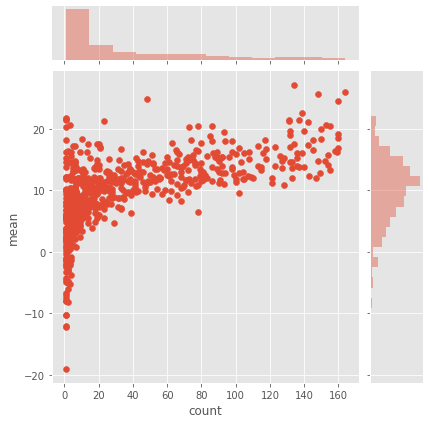

In [0]:
ax = sns.jointplot(x='count', y='mean', data=grouped, kind='scatter')

Тут логичный тренд - старожилы лиги набирают свои очки, достаточно много и очень стабильно.

In [0]:
df.groupby('p_hand').agg('min').age #рандомный groupby из интереса: самые молодые левша и правша

p_hand
0    19
1    20
Name: age, dtype: int8

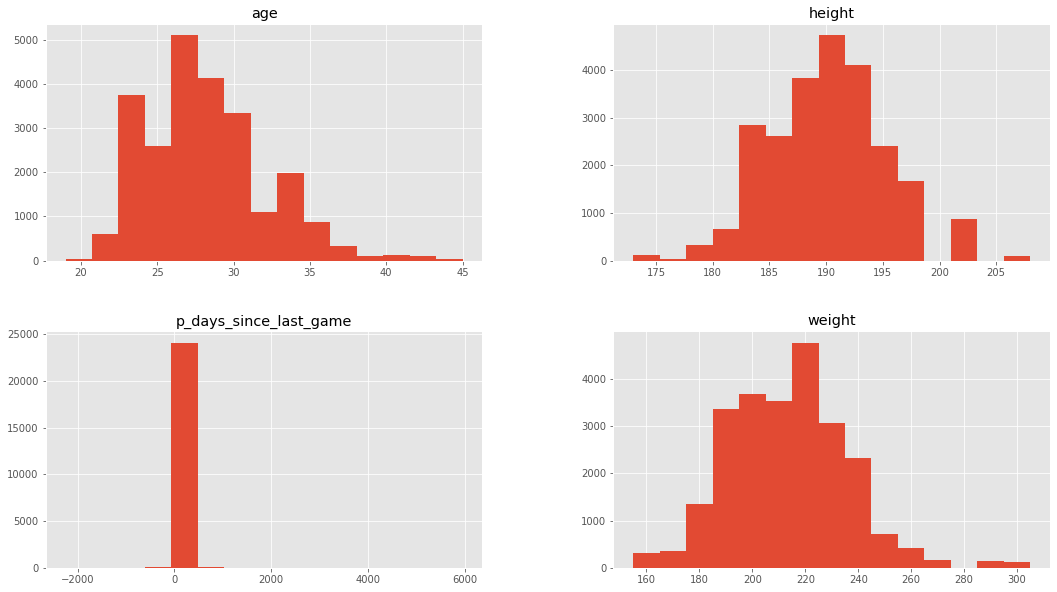

In [0]:
df[['age','height', 'weight', 'p_days_since_last_game']].hist(bins=15, figsize=(18,10));

In [0]:
#df['agecat'] = pd.cut(df['age'], 6, labels=[1,2,3,4,5,6]) #не зашло, ухудшило модель, если дропать age

In [0]:
#df['overweight'] = df['weight'].apply(lambda x:1 if x>230 else 0) #не зашло

у p_days_since_last_game слишком скошено распределение, сделаем лог-трансформацию, чтобы лучше отделять значимость результатов.
Логарифмирование делать вне обучения нормально, поскольку это не связано с какими-то отдельными, новыми или старыми, данными (в отличие от, например, scaling'а и трансформа_ий в виде PCA, SVD, которые делать всегда лучше в пайплайне для каждого фолда при кросс-валидации)
ь
Сначала посмотрим, есть ли отрицательные значения (по ошибке, очевидно). Если есть, то заменим на abs или на 999.

In [0]:
len(df['p_days_since_last_game'][df['p_days_since_last_game']<0])

118

In [0]:
df['p_days_since_last_game'] = df['p_days_since_last_game'].apply(np.log1p)
df['p_days_since_last_game'].fillna(0, inplace=True)

In [0]:
###### Визуальный анализ ######

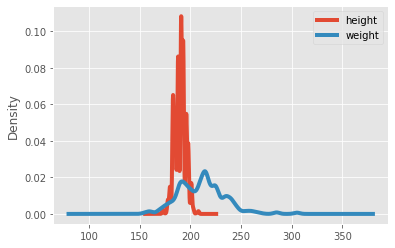

In [0]:
df[['height', 'weight',]].plot.kde();

<Figure size 1440x1800 with 0 Axes>

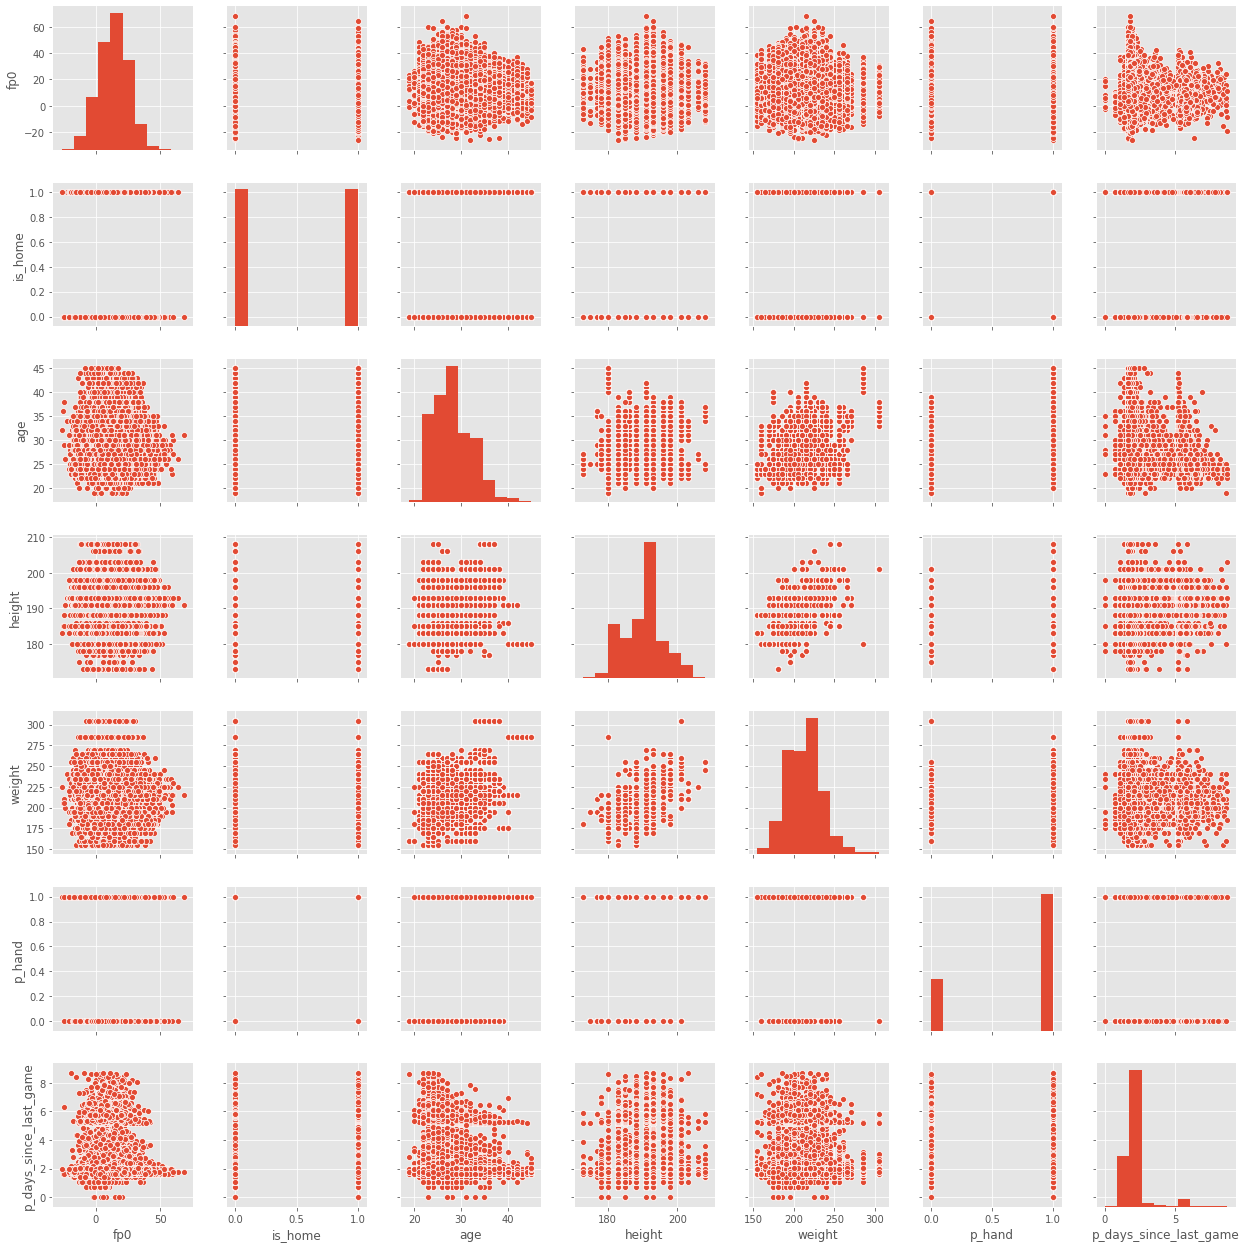

In [0]:
plt.figure(figsize=(20, 25))
sns.pairplot(df.iloc[:,2:9]);

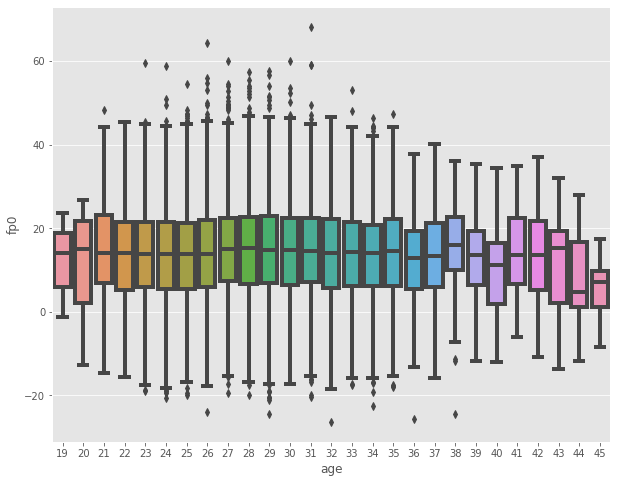

In [0]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='age', y='fp0', data=df);

Из графиков начинают всплывать какие-то аспекты:
- возраст можно разделить по категориям <20, 20-25 и дальше с шагом 5 примерно;
- те, кто старше ~35, НИКОГДА не набирают больше 40 очков;
- те, кто давно не играл, много очков как правило не набивают;
- выскочила совершенно случайная зависимость главной руки и возраста
И другие.

Но мало что можно сказать про коррелированность (кроме разве что того, что height i _eight положительно коррелируют). Посмотрим на матри_у корреля_ии.

In [0]:
print (df.corr())

In [72]:
df.drop(['gamescount_sma1_pg',
               'league_numpitches_sma30_pd_pp',
               'league_numpitches_sma600_pd_pp',
              'numpitches_sma90_pp',
              'league_numpitches_sma300_pd_pp',
              'league_numpitches_sma150_pd_pp',
              'numpitches_sma540_pp',
              'numpitches_sma180_pp',
              'league_numpitches_sma10_pd_pp',
              'numpitches_sma10800_pp',
              'numpitches_sma5400_pp',
              'numpitches_sma2700_pp',
              'league_numpitches_sma75_pd_pp',
              'numpitches_sma1350_pp',
              'league_numpitches_sma450_pd_pp',
              'numpitches_sma8100_pp'], axis=1, inplace=True)

NaN в матрице корреляции бывает только в одном случае - в столбце есть только одно значение и когда мы делим на квадрат выборочной дисперсии по формуле корреляции, знаменатель обращается в ноль. Отсюда и NaN. Сразу убираем эти столбцы. 

Убрал очень грубо, надо написать условие, а не перебирать их конечно. Рано или поздно в них станет по 2 и больше значений. 

In [0]:
'''
Не стал трогать коррелированные фичи, так как в основном это moving averages разной длины

'''


In [0]:
df[df['game_id']==45200]

,day_id,game_id,player_id,fp0,is_home,age,height,weight,p_hand,p_days_since_last_game,...,rbiallowed_sma2700_pp,singleallowed_sma15_pg,earnedruns_sma2_pg,win_sma90_pg,league_fp0_sma300_pd_pg,league_atbatallowed_sma450_pd_pp,hitsagainst_sma120_pg,league_walkallowed_sma150_pd_pp,swingingstrike_sma8100_pp,league_earnedruns_sma10_pd_pp
4,2017-07-24,45200,108,6.1,0,29,196,225,1,5,...,0.030806,2.733333,4.0,0.324312,13.563775,0.231184,5.553976,0.021735,0.103042,0.02938
22167,2017-07-24,45200,17157,22.5,1,32,185,190,1,6,...,0.042295,4.133333,2.5,0.412260,13.563775,0.231184,5.983617,0.021735,0.087667,0.02938


*game_id* нам не нужен в обучении, но понятно, почему он здесь - преобразовывать league_*** фичи после каждой игры

Была идея сгенерить новые фичи на основе старых по принципу player_ / league_ 
(например earnedruns_sma30_pg / league_earnedruns_sma30_pd_pg), 
но таких соответствий немного и непонятно, как отличается 'pg' от 'pd_pg'.

Также отсекал фичи по достигаемому уровню значимости 0.01, 0.05, 0.1 
(h0 гипотеза - фича имеет 0 веса в модели). rmse становится чуть выше, работает в разы быстрее. 
Но поскольку датасет и так небольшой, то лучше все же имхо выжимать по максимуму.


In [0]:
'''
Selected_columns = df.columns[2:].values

def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns

SL = 0.05
data_modeled, selected_columns = backwardElimination(df.iloc[:,2:].values, df.iloc[:,1].values, SL, selected_columns)
dfs = pd.DataFrame(data = data_modeled, columns = selected_columns)
dfs.shape
'''


Сплитим на обучающую и тестовую выборки. Делаем корректно, с поправкой на зависимость данных от времени. Можно взять TimeSeriesSplit, можно руками разбить, если данные уже упорядочены по времени.

In [6]:
def timesplit(X, y, test_size=0.25): #свой простенький timesplit, только для упорядоченных данных
    idx_split=int(X.shape[0]*test_size)
    X_train = X[:-idx_split]
    X_test = X[-idx_split:]
    y_train = y[:-idx_split]
    y_test = y[-idx_split:]
    return X_train, X_test, y_train, y_test

In [0]:
X = df.drop(['fp0', 'day_id', 'game_id'],axis=1)
y = df['fp0']

In [0]:
# train-test split #

X_train, X_test, y_train, y_test = timesplit(X, y, test_size=0.25)
y_train.size/y_test.size

3.0

In [0]:
# train-valid split #

xtrain, xvalid, ytrain, yvalid = timesplit(X_train, y_train, test_size=0.25)

In [0]:
###### Обучение, классический ML ######

In [0]:
regs = []

regs.append(LinearRegression())
regs.append(Lasso(random_state=42))
regs.append(ElasticNet(l1_ratio=0.7, random_state=42))
regs.append(BayesianRidge())
regs.append(lgb.LGBMRegressor(max_depth=-1,
                         n_estimators=100,
                          num_leaves=30,
                          learning_rate=0.05,
                          objective='regression',
                          #eval_metric='rmse',
                          n_jobs=4,
                          reg_alpha=0.7,
                          random_state=42))
regs.append(xgb.XGBRegressor(num_leaves=30, 
           n_estimators=100, 
           objective='reg:mean_squared_error', 
           reg_alpha=0.1,
           learning_rate=0.1,
           #eval_metric='rmse',
           random_state=42,
           n_jobs=4))

In [ ]:
ts = TimeSeriesSplit(n_splits=10)

def cv_scores(pipe, X, y, cv=ts):
    start_time = datetime.now()
    scores = cross_val_score(pipe, X, y, scoring="neg_mean_squared_error", cv=cv, n_jobs=4)
    scores = np.sqrt(-scores)
    print (30*'-')
    print('RMSE oof:', np.round(scores, 3))
    print (30*'-')
    print('Mean:', np.round(scores.mean(),3))
    print (30*'-')
    print('Standard deviation:', np.round(scores.std(),3))
    print (30*'-')
    print ('Обучено за: {}'.format(str(datetime.now() - start_time)))

In [ ]:
for reg in regs:
    pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    #('svd',TruncatedSVD(n_components=50)), 
    ('reg', reg),])
    reg_name = reg.__class__.__name__
    print (30*'_')
    print ('')
    print ('{} :'.format(reg_name))
    cv_scores(pipe, X_train, y_train, cv=ts)

xgboost и lgboost ожидаемо показывают лучшие результаты

После масштабирования в пайплайне пробовал добавить SVD разложения, PCA - неизбежно ухудшало скор. Но с SVD работает намного шустрее.

Посмотрим, насколько улучшится скор LGB и XGB, если обучить их с early_stopping_rounds. 

In [0]:
lgbr = lgb.LGBMRegressor(max_depth=-1,
                         n_estimators=1000,
                         num_leaves=30,
                         learning_rate=0.05,
                         objective='regression',
                         eval_metric='rmse',
                         n_jobs=4,
                         reg_alpha=0.7,
                         random_state=42)
start_time = datetime.now()
lgbr.fit(xtrain, ytrain,
        eval_set=[(xvalid, yvalid)],
        early_stopping_rounds=100,
        verbose=50)
y_pred_lgb = lgbr.predict(X_test, num_iteration=lgbr.best_iteration_)
print (15*'-')
print ('Обучено за: {}'.format(str(datetime.now() - start_time)))
print (15*'-')
print(np.sqrt(mean_squared_error(y_test, y_pred_lgb)))

Training until validation scores don't improve for 100 rounds
[50]	valid_0's l2: 118.015
[100]	valid_0's l2: 117.551
[150]	valid_0's l2: 118.729
Early stopping, best iteration is:
[80]	valid_0's l2: 117.353
---------------
Обучено за: 0:00:09.134829
---------------
10.913550834935657


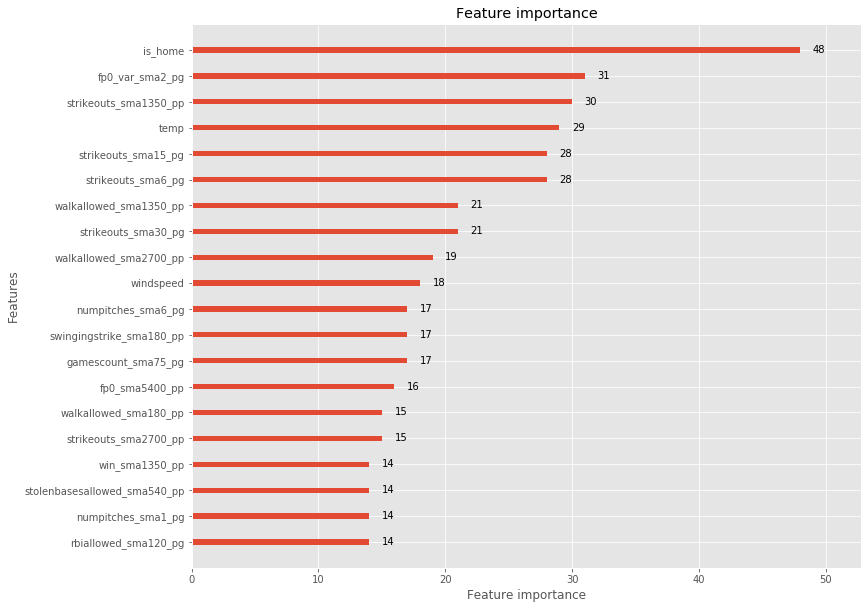

In [0]:
lgb.plot_importance(lgbr, max_num_features=20, figsize=(12, 10))

In [0]:
xgbr = xgb.XGBRegressor(num_leaves=30, 
           n_estimators=1000, 
           objective='reg:squarederror', 
           reg_alpha=0.1,
           learning_rate=0.1,
           eval_metric='rmse',
           random_state=42,
           n_jobs=4)

In [0]:
start_time = datetime.now()
xgbr.fit(xtrain, ytrain,
        eval_set=[(xvalid, yvalid)],
        early_stopping_rounds=100,
        verbose=50)
y_pred_xgb = xgbr.predict(X_test, xgbr.get_booster().best_ntree_limit)
print (15*'-')
print ('Обучено за: {}'.format(str(datetime.now() - start_time)))
print (15*'-')
print(np.sqrt(mean_squared_error(y_test, y_pred_xgb)))

[0]	validation_0-rmse:16.2089
Will train until validation_0-rmse hasn't improved in 100 rounds.
[50]	validation_0-rmse:10.8355
[100]	validation_0-rmse:10.9371
Stopping. Best iteration:
[44]	validation_0-rmse:10.8316

---------------
Обучено за: 0:00:09.998987
---------------
10.831307362282148


In [0]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, 
        n_jobs=4, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid("on") 
    if ylim:
        plt.ylim(ylim)
    plt.title(title)

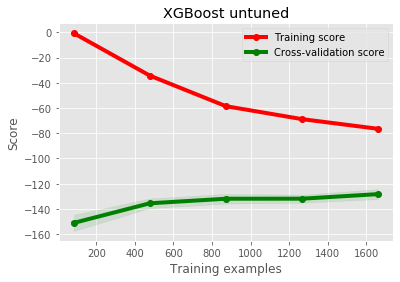

In [0]:
plot_learning_curve(xgbr, "XGBoost untuned",
                    X_train, y_train, cv=ts,
                    train_sizes=np.linspace(.05, 1.0, 5))

Кривые обучения и валидации не сошлись, а значит bias-составляющая ошибки модели велика. Нам скорее всего не хватает примеров для обучения, чтобы улучшить обобщающую способность + надо хорошо затюнить гиперпараметры модели.

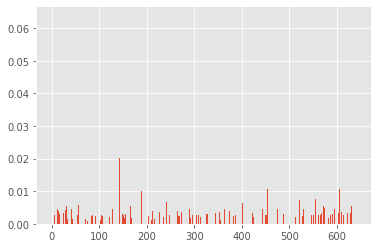

In [0]:
plt.bar(range(len(xgbr.feature_importances_)), xgbr.feature_importances_);

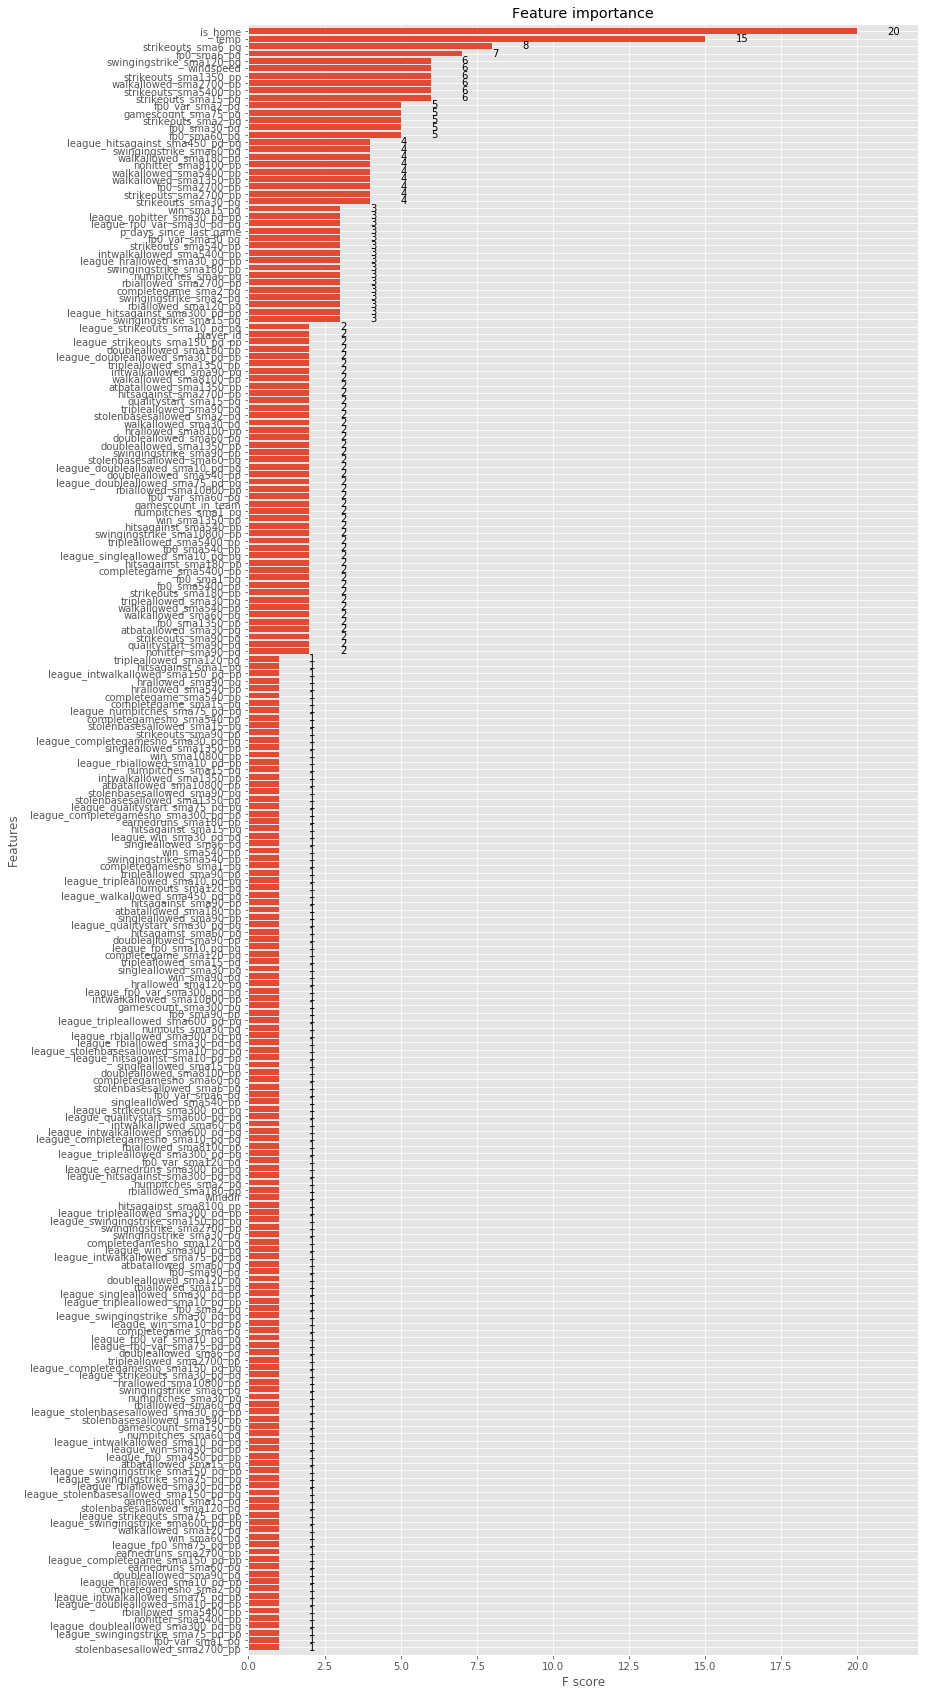

In [0]:
fig, ax = plt.subplots(figsize=(12,30))
xgb.plot_importance(xgbr, max_num_features=-1, height=0.8, ax=ax)
plt.show()

weight 1 это мало или достаточно? Точно не сказать. Однозначно лучше смотреть на gain

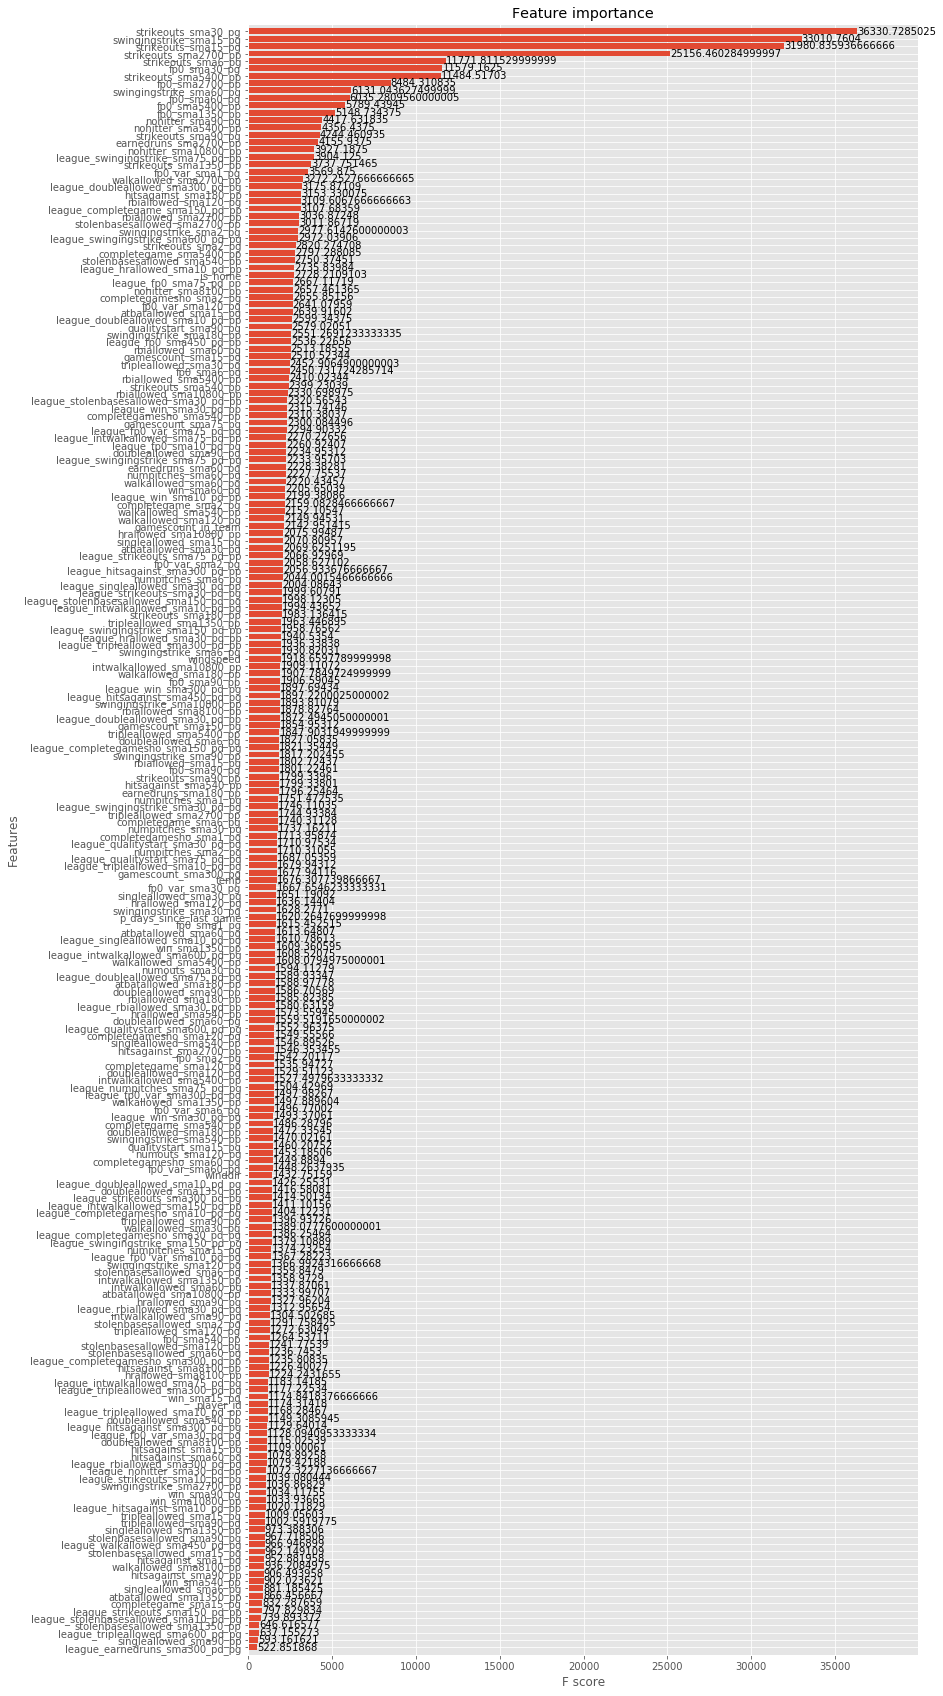

In [0]:
fig, ax = plt.subplots(figsize=(12,30))
xgb.plot_importance(xgbr, max_num_features=-1, height=0.8, ax=ax, importance_type='gain')
plt.show()

Похоже все фичи что-то да вносят. Будем тюнить гиперпараметры и потом немного нейронок для сравнения. 

С ранней остановкой XGB даёт лучший скор, посмотрим на 95% доверительный интервал.

In [0]:
confidence = 0.95
squared_errors = (y_pred_xgb - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(10.647454095798834, 11.012091519339641)

Проверим гипотезу о том, что XGBoost со своими early stopping rounds дает качество лучше, чем LightGBM.

**H0: качество не изменилось**
    
**H1: двусторонняя альтернатива, что качество стало лучше, ну или хуже**

In [0]:
stats.ttest_rel(np.abs(y_pred_xgb), np.abs(y_pred_lgb))

Ttest_relResult(statistic=2.142298778674973, pvalue=0.032209093345930695)

На уровне значимости p=0.05 можем отвергнуть нулевую гипотезу о том, что качество одинаковое.

In [0]:
print ("95%% доверительный интервал для разницы: [%f, %f]" % DescrStatsW(np.abs(y_pred_xgb) - np.abs(y_pred_lgb)).tconfint_mean())

95% доверительный интервал для разницы: [0.003366, 0.075890]


0 в интервал не входит, что опять же говорит о том, что xgb лучше. Тем не менее на кросс-валидации без ранней остановки lgb справился не хуже

In [0]:
# Blending 2*xgboost : 1*lgb #

In [0]:
print (np.sqrt(mean_squared_error(y_test, (2*y_pred_xgb+1*y_pred_lgb)/3)))

10.837491622471221


In [0]:
###### Нейронные сети ######

In [0]:
X_train, X_test, y_train, y_test = timesplit(X, df['fp0'], test_size=0.25)

In [0]:
#nn в отличие от tree-based алгоритмов достаточно чувствительно к масштабам. Просто переведем все фичи в [0,1]
sc = MinMaxScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [0]:
#простая feed-forward сеть, входящую в sklearn пакет
mlp = neural_network.MLPRegressor(solver='adam', alpha=1e-5, activation = 'relu', hidden_layer_sizes=(7, 32, 16), random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print('Mean squared error: %.2f'
      % np.sqrt(mean_squared_error(y_test, y_pred)))

Mean squared error: 11.31


In [0]:
input_dim=X_train.shape[1]

In [0]:
#в keras нет rmse лосса по умолчанию, так что сами напишем
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [0]:
def baseline_model():
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(loss=root_mean_squared_error, optimizer='adam')
    return model

In [0]:
keras = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=100, verbose=False)
start_time = datetime.now()
results = cross_val_score(keras, X_train, y_train, cv=ts)
display_scores(results)
print (15*'-')
print ('Обучено за: {}'.format(str(datetime.now() - start_time)))
print (15*'-')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
------------------------------
RMSE oof: [-11.717 -11.505 -11.325 -11.68  -11.546 -11.462 -11.295 -11.064 -11.279
 -10.832]
------------------------------
Mean: -11.371
------------------------------
Standard deviation: 0.259
---------------
Обучено за: 0:00:46.996436
---------------


In [0]:
keras.fit(X_train, y_train)
preds = keras.predict(X_test)
print('Mean squared error: %.2f'
      % np.sqrt(mean_squared_error(y_test, preds)))

Mean squared error: 11.03


Даже примитивные сети неплохо справляются с задачей.

**Возник вопрос - но как потом выбрать 8 атакующих позиций и 2 питчера из такого датасета и может быть, логичнее поделить датасет на 2 и работать с ними по отдельности?**

В целом не покидало ощущение того, что эти задачи должны решаться не так.

In [0]:
df_pitchers = df.filter(regex='day_id|player_id|fp0|fp0_|is_home|age|height|weight|\
                               temp|walk|atbat|quality|\
                               p_hand|p_days_since_last_game|gamescounts_|\
                               win|strikeouts_|earnedruns_|numpitches_|\
                               hit|numouts|completegame') #читал на сайте
                               
df_offensive = df.filter(regex='day_id|player_id|fp0|fp0|is_home|age|height|weight|\
                               temp|walk|atbat|\
                               p_hand|p_days_since_last_game|gamescounts_|\
                               win|single|double|triple|rbi|hr|run|hit|stolen|')

При разбиении ориентировался на:
>The eight hitting positions earn points as follows.

>Single: 3 Points
Double: 5 Points
Triple: 8 Points
Home Run: 10 Points
RBI: 2 Points
Run: 2 Points
Base on Balls: 2 Points
Hit by Pitch: 2 Points
Stolen Base: 5 Points

>The two pitching positions obviously earn points in a much different way:

>Inning Pitched: 2.25 Point
Strike Out: 2 Points
Win: 4 Points
Earned Run Allowed: -2 Point
Hits Given Up: -0.6 Points
Base on Balls Against: -0.6 Point
Hit by Pitch: -0.6 Points
Complete Game: 2.5 Points
Shutout: 2.5 Points
No Hitter: 5 Points

In [0]:
X = df_pitchers.drop(['day_id','fp0'],axis=1)
y = df_pitchers['fp0']
X_train, X_test, y_train, y_test = timesplit(X, y, test_size=0.25)
xtrain, xvalid, ytrain, yvalid = timesplit(X_train, y_train, test_size=0.25)

In [0]:
for reg in regs:
    pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    #('svd',TruncatedSVD(n_components=50)), 
    ('reg', reg),])
    reg_name = reg.__class__.__name__
    print (30*'_')
    print ('')
    print ('{} :'.format(reg_name))
    cv_scores(pipe, X_train, y_train, cv=ts)

______________________________

LinearRegression :
------------------------------
RMSE oof: [58.44  41.825 17.761 12.475 24.37  15.532 16.851 13.437 13.165 14.524]
------------------------------
Mean: 22.838
------------------------------
Standard deviation: 14.505
------------------------------
Обучено за: 0:00:02.482731
______________________________

Lasso :
------------------------------
RMSE oof: [11.426 11.302 11.445 11.911 11.859 11.785 11.607 11.401 11.643 11.46 ]
------------------------------
Mean: 11.584
------------------------------
Standard deviation: 0.2
------------------------------
Обучено за: 0:00:00.677488
______________________________

ElasticNet :
------------------------------
RMSE oof: [11.426 11.302 11.445 11.911 11.859 11.785 11.607 11.401 11.643 11.46 ]
------------------------------
Mean: 11.584
------------------------------
Standard deviation: 0.2
------------------------------
Обучено за: 0:00:00.647551
______________________________

BayesianRidge :
---

In [0]:
X = df_offensive.drop(['day_id','fp0'],axis=1)
y = df_offensive['fp0']
X_train, X_test, y_train, y_test = timesplit(X, y, test_size=0.25)
xtrain, xvalid, ytrain, yvalid = timesplit(X_train, y_train, test_size=0.25)

In [0]:
for reg in regs:
    pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    #('svd',TruncatedSVD(n_components=50)), 
    ('reg', reg),])
    reg_name = reg.__class__.__name__
    print (30*'_')
    print ('')
    print ('{} :'.format(reg_name))
    cv_scores(pipe, X_train, y_train, cv=ts)

______________________________

LinearRegression :
------------------------------
RMSE oof: [6.65940000e+01 5.95340000e+01 5.53827749e+11 1.74927559e+10
 2.20830000e+01 4.28020000e+01 2.77380000e+01 1.42730000e+01
 1.33740000e+01 1.44190000e+01]
------------------------------
Mean: 57132050555.529
------------------------------
Standard deviation: 165647354498.141
------------------------------
Обучено за: 0:00:02.653352
______________________________

Lasso :
------------------------------
RMSE oof: [11.426 11.302 11.445 11.911 11.859 11.785 11.607 11.401 11.643 11.46 ]
------------------------------
Mean: 11.584
------------------------------
Standard deviation: 0.2
------------------------------
Обучено за: 0:00:01.269953
______________________________

ElasticNet :
------------------------------
RMSE oof: [11.426 11.302 11.445 11.911 11.859 11.785 11.607 11.401 11.643 11.46 ]
------------------------------
Mean: 11.584
------------------------------
Standard deviation: 0.2
--------

Казалось бы, это логично, но видимо потерял какую-то информацию, т.к. средняя ошибка по двум новым не только не упала, но даже чуть-чуть выросла по сравнению с оригинальным датасетом.

## Часть 2.

**Тогда я подумал: нам ведь нужна прогнозная модель для каждого игрока. Так возьмем одного игрока, сделаем time series и попробуем предсказать что-то только для него.**

In [73]:
df = df.set_index('day_id').sort_values(by='day_id', ascending=True).astype('float32')

In [0]:
df412 = df[df['player_id']==412].drop(['game_id'],axis=1)

In [0]:
len(df412)

160

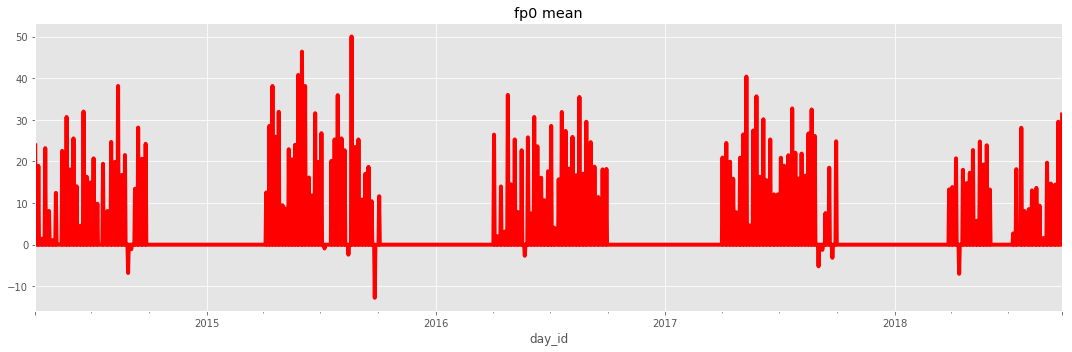

In [0]:
plt.figure(figsize=(15,5))
df412.fp0.resample('D').sum().plot(title='fp0 mean', color='red') 
plt.tight_layout()
plt.show()

Наглядная сезонность :)

In [0]:
X = df412.drop('player_id',axis=1) # 'age','height', 'weight','p_hand' с ними лучше, хотя и не меняются во времени.

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True): 
    #n_in = лаг, n_out = кол-во предсказаний на выходе
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [0]:
reframed = series_to_supervised(X.values, 1, 1)
print (reframed.head(3))

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var623(t)  var624(t)  var625(t)
1  23.900000        1.0       25.0  ...   0.020738   0.093529   0.025582
2  18.950001        0.0       25.0  ...   0.020810   0.093436   0.026609
3   1.450000        0.0       25.0  ...   0.020982   0.093754   0.024988

[3 rows x 1250 columns]


In [0]:
values = reframed.values

In [0]:
n_train_time = int(len(X)*0.80)
train = values[:n_train_time, :]
test = values[n_train_time:, :]
X_train, y_train = train[:, 1:], train[:, 0]
X_test, y_test = test[:, 1:], test[:, 0]

scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# reshape в 3D (сэмплы,timesteps,фичи)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(128, 1, 1249) (128,) (31, 1, 1249) (31,)


---------------
RMSE: 4.3979997634887695
---------------
Обучено за: 0:00:19.213128


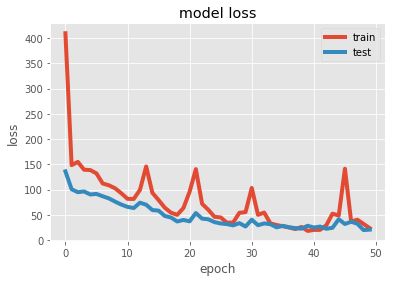

In [0]:
start_time = datetime.now()
model = Sequential()
model.add(LSTM(100, 
               activation='relu', 
               return_sequences=True, 
               input_shape=(X_train.shape[1], X_train.shape[2]), 
               activity_regularizer=reg))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


history = model.fit(X_train, 
          y_train, 
          epochs=50, 
          batch_size=10, 
          validation_data=(X_test, y_test), 
          verbose=0, 
          shuffle=False)
model.reset_states()

y_pred = model.predict(X_test, batch_size=1)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print (15*'-')
print ('RMSE: {}'.format(np.round(rmse, 3)))
print (15*'-')
print ('Обучено за: {}'.format(str(datetime.now() - start_time)))
#кривые обучения-валида_ии
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Тут много чего происходит, начиная от стека LSTM слоев и заканчивая изменением размера батчей на 1 для предсказаний (таким образом мы делаем 1 предсказание за раз, а для time series это нам и надо по сути)

"Рывки" на графике из-за батч сайза 10 при 128 длине сэмпла. График хороший, в идеале добавить еще эпох, можно попробовать завязать батч сайз на длину сэмпла. Здесь можно еще много что сделать.

Считаю, что регуляризаторы хотя бы на выход слоя (activity) + дропауты нужны, чтобы уменьшить риск страшного оверфита.

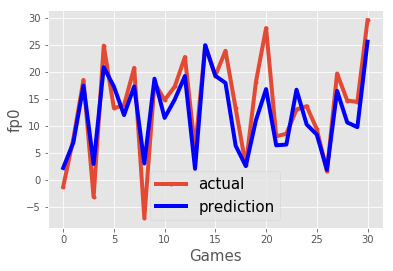

In [0]:
forecast=[x for x in range(y_test.shape[0])]
plt.plot(forecast, y_test, marker='.', label="actual")
plt.plot(forecast, y_pred, 'b', label="prediction")
plt.ylabel('fp0', size=15)
plt.xlabel('Games', size=15)
plt.legend(fontsize=15)
plt.show()

In [0]:
predictions = []
for i in zip(np.round(y_pred[:,0],2), y_test):
  predictions.append(i)

In [0]:
p412_forecast = pd.DataFrame.from_records(predictions, index=X[n_train_time+1:].index, columns=['predicton','actual'])
p412_forecast.head(10)

,predicton,actual
day_id,,
2017-09-13,2.230000,-1.25
2017-09-19,6.920000,7.60
2017-09-24,17.450001,18.50
2017-09-30,2.980000,-3.15
2018-03-29,20.870001,24.85
2018-04-03,17.290001,13.30
2018-04-09,12.020000,13.85
2018-04-14,17.309999,20.75
2018-04-20,3.070000,-7.00


Тут, конечно, будут проблемы с игроками, у которых маленькое количество выходов на поле. 

Для них мы позже сделаем кластеризацию (очевидный пример это **kmeans**, а вообще какой алгоритм брать и как его правильно настроить это отдельная тема), а пока итеративненько пройдемся по каждому игроку и сделаем предсказания.

In [75]:
df['totalgames'] = df.groupby('player_id')['game_id'].transform('size')

In [76]:
dfo = df.copy()
nbdf = df[df['totalgames']<=15] #делим на 2 датасета
df = df[df['totalgames'] > 15]

Думаю, здесь 5-10 примеров это адекватный порог.

In [12]:
nbdf.head(5)

,day_id,game_id,player_id,fp0,is_home,age,height,weight,p_hand,p_days_since_last_game,...,singleallowed_sma15_pg,earnedruns_sma2_pg,win_sma90_pg,league_fp0_sma300_pd_pg,league_atbatallowed_sma450_pd_pp,hitsagainst_sma120_pg,league_walkallowed_sma150_pd_pp,swingingstrike_sma8100_pp,league_earnedruns_sma10_pd_pp,totalgames
23606,2018-09-30,48573,19208,3.4,0,25,193,180,1,7,...,3.687576,2.500000,0.299644,13.801954,0.228407,5.440336,0.021473,0.102357,0.028229,14
23874,2018-09-30,48577,19322,6.8,0,25,196,230,1,2,...,3.392124,3.500000,0.324562,13.801954,0.228407,5.407034,0.021473,0.104223,0.028229,4
24115,2018-09-30,48574,19399,9.4,1,22,193,220,1,2,...,3.079700,4.072727,0.320656,13.801954,0.228407,5.405373,0.021473,0.104779,0.028229,2
23393,2018-09-30,48581,19141,8.6,1,26,191,205,1,3,...,3.094093,0.500000,0.302642,13.801954,0.228407,5.363691,0.021473,0.103677,0.028229,7
24273,2018-09-30,48572,19538,13.8,0,26,191,215,1,4,...,3.335912,3.500000,0.317053,13.801954,0.228407,5.410370,0.021473,0.105845,0.028229,3


Теперь к сути.

In [13]:
#rmses = []
reg = regularizers.L1L2(l1=0.000, l2=0.001)
dfpreds = pd.DataFrame() 

In [0]:
def training_function(df, df_for_predictions): 
    totalgames = df.groupby('player_id').size() #колво игр
    for i, v in zip(totalgames.index, totalgames.values):
        X = df[df['player_id']==i]
        seq = series_to_supervised(X.drop(['totalgames','game_id','player_id'],axis=1).values, 1, 1).values
      
        n_train_time = int(len(X)*0.75)
        train = seq[:n_train_time, :]
        test = seq[n_train_time:, :]

        X_train, y_train = train[:, 1:], train[:, 0]
        X_test, y_test = test[:, 1:], test[:, 0]

        scaler = MinMaxScaler(feature_range=(0, 1)) #работает лучше остальных здесь
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

        model = Sequential()
        model.add(LSTM(100,
                       activation='relu', 
                       return_sequences=True, 
                       input_shape=(X_train.shape[1], X_train.shape[2]), 
                       activity_regularizer=reg))
        model.add(LSTM(32, activation='relu'))
        model.add(Dropout(0.1))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')

        history = model.fit(X_train, 
                            y_train,
                            epochs=50,
                            batch_size=10,
                            validation_data=(X_test, y_test),
                            verbose=0, 
                            shuffle=False)
        model.reset_states()

        y_pred = model.predict(X_test, batch_size=1)
    #rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    #rmses.append(np.round(rmse, 3))
      
        predictions = []
        for i in zip(np.round(y_pred[:,0],2), y_test):
            predictions.append(i)
  
        df_new = pd.DataFrame({'Predictions':predictions}, 
                            index=[X[n_train_time+1:]['player_id'], 
                                   X[n_train_time+1:]['player_id'].index])
        df_for_predictions = pd.concat([df_for_predictions, df_new]).sort_index()
    
    return df_for_predictions
    

In [ ]:
dfpreds = training_function(df, dfpreds)

In [4]:
dfpreds = (pd.read_csv('dfpreds.csv', skipinitialspace=True)
           .set_index(['player_id', 'day_id'])
           .sort_values('Predictions', ascending=False)
           .sort_index(level=[0], ascending=[True]))

Также посмотрим на rmse.

In [7]:
dfpreds['rmse'] = (dfpreds['Predictions']-dfpreds['Actual'])**2
print (60*'-')
print ('RMSE предсказаний для игроков с кол-вом игр больше 15: {}'.format(np.round(np.sqrt(dfpreds.rmse.mean()), 3)))
print (60*'-')

------------------------------------------------------------
RMSE предсказаний для игроков с кол-вом игр больше 15: 18.313
------------------------------------------------------------


In [8]:
dfpreds

Predictions  Actual       rmse
player_id day_id                                    
108.0     2017-07-02        14.28   13.85     0.1849
          2017-07-24        10.08   17.30    52.1284
          2017-07-07         8.59   11.05     6.0516
          2017-06-27         8.29   12.65    19.0096
          2017-07-14         6.10    8.45     5.5225
          2017-07-29         4.38    6.10     2.9584
          2017-07-19         3.44    1.75     2.8561
          2017-08-07         0.77   -4.25    25.2004
273.0     2014-09-28        14.63   21.65    49.2804
          2014-09-23        13.37   15.50     4.5369
          2015-04-12         6.82   12.15    28.4089
          2015-04-06         6.20   13.15    48.3025
          2017-09-30         5.09   10.45    28.7296
          2017-09-17         3.51    1.25     5.1076
          2015-05-22         0.77   -2.60    11.3569
          2015-05-17         0.16    4.45    18.4041
          2017-09-23        -0.87    7.65    72.5904
313.0     2018-08-27        15.60   30.55   223.5025
          2018-05-07        14.12   14.65     0.2809
          2018-05-02        13.89   15.45     2.4336
          2018-07-14        13.49   18.25    22.6576
          2018-07-28        13.24   20.70    55.6516
          2018-08-15         6.71   12.85    37.6996
          2018-08-21         6.55   18.25   136.8900
          2018-08-10         5.27   17.95   160.7824
          2018-07-08         5.11    1.05    16.4836
          2018-05-18         2.58    5.25     7.1289
          2018-09-25         2.42   23.20   431.8084
          2018-07-23         0.23   -1.90     4.5369
          2018-08-03        -1.60    2.10    13.6900
...                           ...     ...        ...
19329.0   2018-09-10        12.20   22.25   101.0025
          2018-08-31         8.25   -3.45   136.8900
          2018-09-16         5.68   -1.45    50.8369
          2018-09-22         3.81    7.05    10.4976
          2018-09-28         2.49   10.45    63.3616
19348.0   2018-09-06         6.69   13.45    45.6976
          2018-09-15         2.72   22.00   371.7184
          2018-09-21         0.14   11.65   132.4801
          2018-09-28         0.02   19.65   385.3369
          2018-08-30        -0.37    5.85    38.6884
19370.0   2018-09-16        19.12    8.45   113.8489
          2018-09-08        14.06    1.60   155.2516
          2018-09-22        12.29   12.95     0.4356
          2018-09-28         7.29   12.45    26.6256
19387.0   2018-09-10         6.86   18.70   140.1856
          2018-09-16         6.04   13.45    54.9081
          2018-09-22         2.08   16.70   213.7444
          2018-09-29         0.49    4.70    17.7241
19390.0   2018-09-16        22.45   37.40   223.5025
          2018-09-11        21.08   19.45     2.6569
          2018-09-06        16.54    6.60    98.8036
          2018-09-26         6.41    6.10     0.0961
19423.0   2018-09-23         0.03   33.60  1126.9449
          2018-09-29        -0.05   21.55   466.5600
          2018-09-17        -0.54   17.25   316.4841
          2018-09-11        -1.30   15.90   295.8400
19549.0   2018-09-17        17.32   26.15    77.9689
          2018-09-05        17.09   22.40    28.1961
          2018-09-11        11.66   16.55    23.9121
          2018-09-23        10.43   12.90     6.1009

[6285 rows x 3 columns]

Можно свапнуть levels и смотреть на игроков за конкретную дату. А сейчас посмотрим на rmse.

Впечатляющий результат. Можно предположить, что для оставшихся игроков rmse будет больше, однако LSTM сети все же явно справляются лучше "классического" ML и сейчас это действительно прогнозная модель. Остается только обучить модель на всех данных (делать сейчас не станем, это достаточно долго) и получать предсказания. 

Осталось разобраться с новенькими игроками и просто игроками, которые редко выходят на поле. Навскидку главных идеи две:
 - разделить ВСЕХ игроков на кластеры и соответственно обучить модель для объектов в виде кластеров, отдельно "вытащив" все метки игроков для кластера
 - разделить только игроков с кол-вом игр < 15 и обучить для них отдельную сеть

In [ ]:
for col in dfo.filter(regex='league').columns: #без league specific фич
    dfo.drop(col, axis=1, inplace=True)

Text(0.5, 1.0, 'PCA')

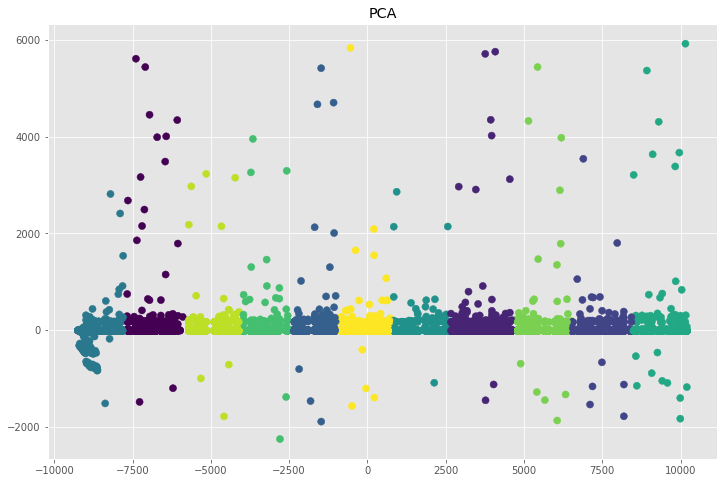

In [151]:
kmeans = KMeans(n_clusters=11, random_state=42, init='k-means++')
numeric_cols = dfo.iloc[:,1:]._get_numeric_data().dropna(axis=1)
kmeans.fit(numeric_cols)


# визуализируем с помощью PCA
pca = PCA(n_components=2)
res = pca.fit_transform(numeric_cols)
plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=kmeans.labels_, s=50)
plt.title('PCA')

Почему все такое странное в этом датасете? Вот бы кто объяснил) пока сравним с dbscan-ом

Text(0.5, 1.0, 'PCA')

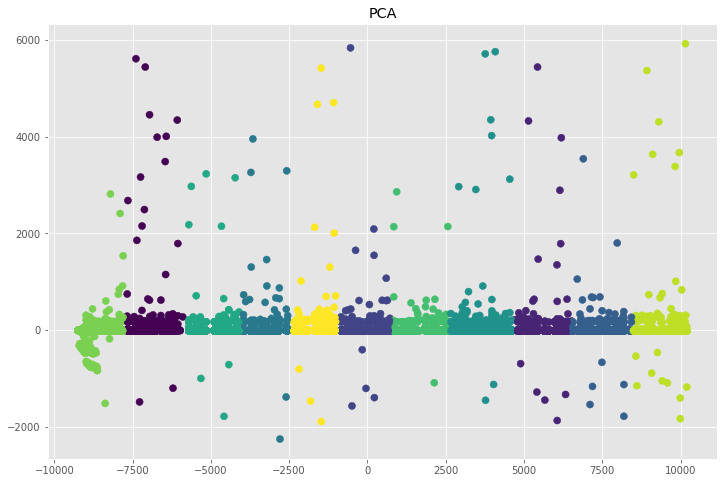

In [167]:
from sklearn.cluster import DBSCAN

dbs = DBSCAN(min_samples=150, n_jobs=4)
numeric_cols = dfo.iloc[:,1:]._get_numeric_data().dropna(axis=1)
dbsres = dbs.fit(numeric_cols)


# визуализируем с помощью PCA
pca = PCA(n_components=2)
res = pca.fit_transform(numeric_cols)
plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=kmeans.labels_, s=50)
plt.title('PCA')

In [173]:
dbsres.components_[:,1]

array([], dtype=float64)

In [182]:
cluster_map = pd.DataFrame() #что-нибудь такое для player<->cluster 
cluster_map['Player'] = dfo['player_id'].values
cluster_map['cluster'] = kmeans.labels_ 

In [186]:
cluster_map = cluster_map.drop_duplicates().reset_index(drop=True)
cluster_map.iloc[:5]

,Player,cluster
0,11523.0,10
1,8973.0,7
2,2401.0,3
3,14901.0,6
4,2699.0,3


In [189]:
cluster_map['cluster'].value_counts()

8     168
5      59
0      55
3      49
9      48
10     45
1      45
2      44
7      43
6      42
4      42
Name: cluster, dtype: int64

Далее по каждому кластеру возьмем предсказания для тех, чей прогноз уже известен, усредним и будет использовать результат как предсказание для неизвестных.

Пожалуй, на этом закончу. Честно говоря, не сталкивался ранее с подобной задачей и не уверен, что классические ML модели в том виде, в котором они выше в этом ноутбуке, хоть сколько-нибудь конкурентноспособны.

**Осталось за бортом:**

- hyperopt/randomizedsearchcv оптимизация гиперпараметров для xgb.

- больше шагов назад во времени для lstm предсказаний (оч долго пересчитывать)

- попробовать обучить sARIMA и заблендить с нейросетями, т.к. у них принципиально разный подход к timeseries

**Варианты и идеи для улучшения:**

- фичи на основе команды соперника (скажем, если питчер соперника получил травму, то вероятность получить больше очов у всех 8 атакующих позиций должна возрастать с точки зрения человеческой логики. Другой пример - против сильных оппонентов в целом очков будет поменьше. И т.п.)

Спасибо, было слегка непонятно и интересно!